## GLM Demo: multivariate song stimulus

This demo estimates GLM parameters using song stimuli. The song waveform is processed to a 2D spectrogram, then convolved with a 2D STRF to produce the "voltage" of the GLM model. The adaptation "current" is calculated by convolving the spike trains with two exponential kernels. The goal of the assimilation is to estimate the parameters of the RF and the adaptation kernels. The parameter count of the RF is minimized by using a low-rank approximation (i.e., an outer product of two vectors) and by projecting time into a basis set of raised cosine filters that are spaced exponentially.

This notebook also demonstrates the use of elastic-net penalized maximum-likelihood estimation to regularize parameter estimates.

In [26]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np

from dstrf import strf, mle, simulate, filters, models

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package

sns.set_style("whitegrid")
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

In [43]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 2
    len: 40
    ncos: 12
data:
  dt: 3.0
  spectrogram:
    window: 4.0
    compress: 10
    f_min: 1000
    f_max: 8000
  filter:
    fn: "gabor"
    nfreq: 20
    ntau: 40
    f_max: 8000
    f_peak: 4000
    t_peak: 12
    ampl: -0.1
    t_sigma: 6
    f_sigma: 2400
    theta: 0
    lmbda: 19
    psi: 1.5
  adaptation: [7.0, 100.0, 2.0]
  trial_noise:
    sd: 2.0
  random_seed: 1
  trials: 5

<IPython.core.display.Javascript object>

In [44]:
from munch import munchify
cf = munchify(cfg)

In [45]:
model_dt = cf.model.dt
stim_dt = cf.data.dt
upsample = int(stim_dt / model_dt)
ntau = cf.model.filter.len
nfreq = cf.data.filter.nfreq
ncos = cf.model.filter.ncos
krank = cf.model.filter.rank

This code generates the simulated response. First we convolve the stimulus with the RF and then use the MAT model to generate spikes from a non-homogeneous Poisson process (optionally using a softplus nonlinearity, which makes the model not-quite-Poisson)

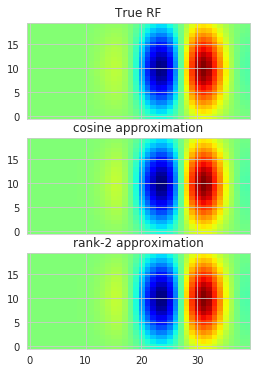

In [46]:
k1, _, _ = filters.gabor(**cf.data.filter)
kcosbas = strf.cosbasis(ntau, ncos)
k1c = strf.to_basis(k1, kcosbas)
k1f, k1t = strf.factorize(k1c, rank=krank)
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(4, 6))
axes[0].imshow(k1, cmap="jet", aspect="auto")
axes[0].set_title("True RF")
axes[1].imshow(strf.from_basis(k1c, kcosbas), cmap="jet", aspect="auto")
axes[1].set_title("cosine approximation")
k1v = np.concatenate([k1f.flatten(), k1t.flatten()])
axes[2].imshow(strf.from_basis(strf.defactorize(k1v, nfreq, krank), kcosbas), cmap='jet')
axes[2].set_title("rank-{} approximation".format(krank));

Here we load some data from a real neural recording from the CRCNS dataset. We're going to replace the actual neural response with a simulation based on the dstrf model. In the original experiment, stimuli were presented individually in a pseudorandom order. To simplify the model, we concatenate the stimuli, setting padding between the stimuli sufficient to capture any offset responses.

The method of concatenation is a bit clumsy, because we don't know what was "presented" during the silent gaps.

In [47]:
pad_before = 0    # how much to pad stimulus before onset
pad_after = ntau * stim_dt # how much to pad after offset
n_trials = 5      # set the number of trials to use (needs to be the same for all stimuli)
p_test = 0.2      # proportion of trials to use for test

# song stimulus:
root = os.path.join(os.environ["HOME"], "data", "crcns")
cell = "blabla0903_2_B"
stim_type = "conspecific"
data = io.load_crcns(cell, stim_type, root, cf.data.spectrogram.window, stim_dt, 
                     f_min=cf.data.spectrogram.f_min / 1000, 
                     f_max=cf.data.spectrogram.f_max / 1000, 
                     f_count=nfreq, 
                     compress=cf.data.spectrogram.compress, 
                     gammatone=True)
io.pad_stimuli(data, pad_before, pad_after, fill_value=0.0);

In [48]:
import mat_neuron._model as mat
mat.random_seed(1)

def predict_spikes(V, dt, upsample):
    omega, a1, a2 = cf.data.adaptation
    t1, t2 = cf.model.ataus
    tref = cf.model.t_refract
    if nlin == "exp":
        f = mat.predict_poisson
    elif nlin == "softplus":
        f = mat.predict_softplus
    return f(V - omega, (a1, a2), (t1, t2), tref, dt, upsample)

for d in data:
    nchan, nframes = d["stim"].shape
    nbins = nframes * upsample
    spike_v = np.zeros((nbins, n_trials), dtype='i')
    spike_h = np.zeros((nbins, len(cf.model.ataus), n_trials), dtype='d')
    V = strf.convolve(d["stim"], k1)
    spike_t = []
    for i in range(n_trials):
        spike_v[:, i] = models.predict_spikes_glm(V, cf.data.adaptation, cf)
        spike_h[:, :, i] = mat.adaptation(spike_v[:, i], cf.model.ataus, model_dt)
        spike_t.append(spike_v.nonzero()[0])
    d["spike_v"] = spike_v
    d["spike_h"] = spike_h
    d["spike_t"] = spike_t
    d["spike_dt"] = model_dt
    
n_test = int(p_test * len(data))
# split into assimilation and test sets and merge stimuli
assim_data = io.merge_data(data[:-n_test])
test_data = io.merge_data(data[-n_test:])

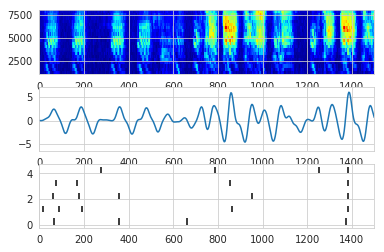

In [49]:
plt.subplot(311).imshow(assim_data["stim"], 
                        extent=(0, assim_data["duration"], 
                                cf.data.spectrogram.f_min, 
                                cf.data.spectrogram.f_max))
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])
V = strf.convolve(assim_data["stim"], k1)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for i, spk in enumerate(assim_data["spike_t"]):
    ax.vlines(spk * model_dt, i, i + 0.5)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 1500)

## Estimate parameters

Construct the factorized estimator.

In [ ]:
# low-rank estimators
try:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"], nlin=nlin)
except TypeError:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"], nlin=nlin)    
# also construct an estimator for the test data so we can score results
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"], nlin=nlin)

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for the initial ML estimation. We'll start with some fairly moderate regularization just to get an initial estimate.

In [ ]:
%time w0 = mlest.estimate(reg_lambda=1e1, reg_alpha=1e1)

In [ ]:
print("True rate and adaptation parameters:", matparams[:3])
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE")

We're now going to select regularization parameters using cross-validation. This makes use of the scikit-learn package.

In [ ]:
import progressbar
from dstrf import crossvalidate

#reg_grid = np.logspace(-1, 5, 50)[::-1]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]
reg_grid = np.logspace(-1, 5, 20)[::-1]
scores = []
results = []

bar = progressbar.ProgressBar(max_value=len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])
for reg, s, w in bar(crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False)):
    scores.append(s)
    results.append((reg, s, w))
    
best_idx = np.argmax(scores)
best = results[best_idx]
print("best solution at {}: {}".format(best[0], best[1]))
rf_alpha, rf_lambda = best[0]
w0 = best[2]

In [ ]:
print("True rate and adaptation parameters:", matparams[:3])
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE")

In [ ]:
mat.random_seed(1)
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))
V = mltest.V(w0)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * model_dt, j, j + 0.5, 'r')
pred = np.zeros_like(test_data["spike_v"])
for i in range(j):
    pred[:, i] = mltest.predict(w0, matparams[3:], V)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * model_dt, i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("loglike: {}".format(-mltest.loglike(w0)))
print("EO cc: %3.3f" % eo)
print("pred cc: %3.3f" % np.corrcoef(test_psth, pred_psth)[0, 1])
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))

We'll use the ML estimate to seed the MCMC sampler. We're going to reduce the size of the parameter space by factorizing the RF (i.e., a bilinear approximation). Note that we try to use the mlest object as much as possible to do the calculations rather than reimplement things; however, there can be some significant performance enhancements from an optimized implementation.

In [ ]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos

# the MAT parameters are just bounded between reasonable limits. These may need to be expanded when using real data.
mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

rf_alpha, rf_lambda = best[0]

def lnpost(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    #rf_prior = -np.sum(np.abs(rfparams)) * rf_alpha - np.dot(rfparams, rfparams) * rf_lambda
    ll = mat_prior(mparams) #+ rf_prior
    if not np.isfinite(ll):
        return -np.inf
    ll -= mlest.loglike(theta, rf_lambda, rf_alpha)
    return -np.inf if not np.isfinite(ll) else ll

In [ ]:
print("lnpost of ML estimate: {}".format(lnpost(w0)))
%timeit lnpost(w0)

This code starts the MCMC sampler. We initialize the walkers (chains) in a gaussian around the ML estimate, with standard deviation 2x the absolute value of the best guess. The model converges fairly quickly, but then we let it sample for a while.

In [ ]:
import emcee
# assimilation parameters
if sys.platform == 'darwin':
    nthreads = 1
else:
    nthreads = 8
nwalkers = 1500
nsteps = 1000

# initialize walkers
pos = p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 2)
# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, w0.size, lnpost, threads=nthreads)

In [ ]:
# start the sampler
tracker = utils.convergence_tracker(nsteps, 100)
for pos, prob, like in tracker(sampler.sample(pos, iterations=nsteps, storechain=True)): 
    continue

In [ ]:
w1 = np.median(pos, 0)
rfparams = w1[3:]
rf_map = strf.from_basis(strf.defactorize(rfparams, nfreq, krank), kcosbas)

print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
print("True rate and adaptation parameters:", matparams[:3])
print("MLE rate and adaptation parameters:", w0[:3])
print("MAP rate and adaptation parameters:", w1[:3])

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 0].set_title("MLE")
axes[1, 1].imshow(rf_map, cmap='jet', aspect='auto')
axes[1, 1].set_title("MAP")

In [ ]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:3]
matlabs = ['w','a1','a2',]
c = corner(mpos,
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams[:3])

In [ ]:
mat.random_seed(1)
n_draw = 10
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))
vax = plt.subplot(312)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * model_dt, j, j + 0.5, 'r')
    
samples = np.random.permutation(nwalkers)[:n_draw]
pred = np.zeros((test_data["spike_v"].shape[0], n_draw), dtype=test_data["spike_v"].dtype)
for i, idx in enumerate(samples):
    mparams = pos[idx]
    V_mc = mltest.V(mparams)
    vax.plot(t_stim, V_mc)
    pred[:, i] = mltest.predict(mparams, matparams[3:], V_mc)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * model_dt, i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("loglike: {}".format(-mltest.loglike(w1)))
print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum() / n_trials, pred.sum() / n_draw))

In [ ]:
# save data for testing in the Pillow code
import scipy.io as sio
V = mlest.V_interp(theta_true).squeeze()
H = assim_resp[0]["H"]
mu = V - H[:, 0] * matparams[1] - H[:, 1] * matparams[2] - matparams[0]
sio.savemat('glmat_2dbi_song_twin.mat', {"stim": (stim - stim.mean(1)[:, np.newaxis]) / stim.std(1)[:, np.newaxis], 
                                         "spikes": assim_resp[0]["spike_v"],
                                         "stim_dt": stim_dt,
                                         "spike_dt": model_dt,
                                         "rf": k1,
                                         "Istim": V,
                                         "Itot": mu})